In [0]:
!pip install tensorflow-gpu keras tensorflow-hub

In [36]:
import tensorflow as tf
import pandas as pd
import os
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.style as style
from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers
from time import time
print("TF version:", tf.__version__)

TF version: 2.2.0-rc3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [37]:
cd /content/drive/My Drive/DeepFashion2

/content/drive/My Drive/DeepFashion2


In [35]:
len(os.listdir('new_train'))

4479

In [32]:
style.use("default")
plt.figure(figsize=(12,4))
plt.imshow(Image.open('new_train/000001.jpg'))
plt.title('test', size=10)
plt.axis('off')

FileNotFoundError: ignored

<Figure size 1200x400 with 0 Axes>

In [0]:
# zip_file=tf.keras.utils.get_file(origin='', 
#   fname='dataset.zip', extract=True)
# train_dir = os.path.join(os.path.dirname(zip_file),'new_train')
# validation_dir = os.path.join(os.path.dirname(zip_file),'new_test')

In [38]:
!unzip dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: new_train/039593.jpg    
  inflating: new_train/039594.jpg    
  inflating: new_train/039595.jpg    
  inflating: new_train/039596.jpg    
  inflating: new_train/039598.jpg    
  inflating: new_train/039599.jpg    
  inflating: new_train/039600.jpg    
  inflating: new_train/039609.jpg    
  inflating: new_train/039610.jpg    
  inflating: new_train/039611.jpg    
  inflating: new_train/039612.jpg    
  inflating: new_train/039616.jpg    
  inflating: new_train/039617.jpg    
  inflating: new_train/039618.jpg    
  inflating: new_train/039619.jpg    
  inflating: new_train/039620.jpg    
  inflating: new_train/039621.jpg    
  inflating: new_train/039622.jpg    
  inflating: new_train/039623.jpg    
  inflating: new_train/039624.jpg    
  inflating: new_train/039627.jpg    
  inflating: new_train/039634.jpg    
  inflating: new_train/039635.jpg    
  inflating: new_train/039653.jpg    
  inflating: new_train/039654.jpg    

In [0]:
IMG_SIZE = 224  
CHANNELS = 3

In [0]:
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [0]:
BATCH_SIZE = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 1024

In [0]:
def create_dataset(filenames, labels, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    if is_training == True:
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
    
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(buffer_size=AUTOTUNE)

        return dataset


In [43]:
train = pd.read_csv('new_train.csv')
train.category = train.category.apply(lambda s: [l for l in str(s).split(',')])
print(train.head())
train_files = [os.path.join('new_train', file) for file in train.image]
train_labels = list(train.category)

        image source                       category    id
0  000001.jpg   user  [short sleeve top,  trousers]  1, 8
1  000003.jpg   user            [long sleeve dress]    11
2  000004.jpg   user            [long sleeve dress]    11
3  000005.jpg   user            [long sleeve dress]    11
4  000006.jpg   user            [long sleeve dress]    11


In [44]:
test = pd.read_csv('new_test.csv')
test.category = test.category.apply(lambda s: [l for l in str(s).split(',')])
print(test.head())
test_files = [os.path.join('new_test', file) for file in test.image]
test_labels = list(test.category)

        image source              category  id
0  000003.jpg   user  [short sleeve dress]  10
1  000004.jpg   user  [short sleeve dress]  10
2  000005.jpg   user    [short sleeve top]   1
3  000006.jpg   user          [vest dress]  12
4  000007.jpg   user          [vest dress]  12


In [0]:
xtrain, xtest, ytrain, ytest = train_files, test_files, train_labels, test_labels

In [46]:
test_files

['new_test/000003.jpg',
 'new_test/000004.jpg',
 'new_test/000005.jpg',
 'new_test/000006.jpg',
 'new_test/000007.jpg',
 'new_test/000008.jpg',
 'new_test/000009.jpg',
 'new_test/000011.jpg',
 'new_test/000012.jpg',
 'new_test/000013.jpg',
 'new_test/000014.jpg',
 'new_test/000016.jpg',
 'new_test/000017.jpg',
 'new_test/000018.jpg',
 'new_test/000019.jpg',
 'new_test/000020.jpg',
 'new_test/000021.jpg',
 'new_test/000022.jpg',
 'new_test/000023.jpg',
 'new_test/000024.jpg',
 'new_test/000025.jpg',
 'new_test/000026.jpg',
 'new_test/000030.jpg',
 'new_test/000032.jpg',
 'new_test/000033.jpg',
 'new_test/000034.jpg',
 'new_test/000035.jpg',
 'new_test/000036.jpg',
 'new_test/000037.jpg',
 'new_test/000038.jpg',
 'new_test/000039.jpg',
 'new_test/000040.jpg',
 'new_test/000041.jpg',
 'new_test/000045.jpg',
 'new_test/000049.jpg',
 'new_test/000050.jpg',
 'new_test/000051.jpg',
 'new_test/000052.jpg',
 'new_test/000053.jpg',
 'new_test/000055.jpg',
 'new_test/000059.jpg',
 'new_test/00006

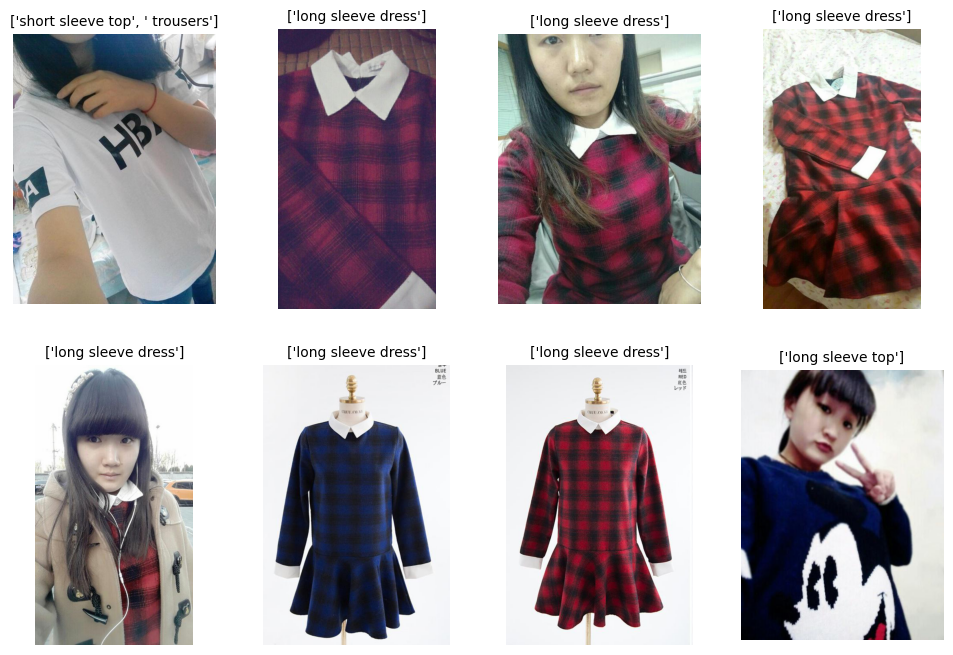

In [47]:
nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(xtrain[i]))
    plt.title(ytrain[i], size=10)
    plt.axis('off')

In [82]:
mlb = MultiLabelBinarizer()
mlb.fit(ytrain)
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("'{}',".format(label))

' long sleeve top',
' short sleeve top',
' shorts',
' skirt',
' trousers',
'long sleeve dress',
'long sleeve top',
'short sleeve dress',
'short sleeve top',
'shorts',
'trousers',
'vest dress',


In [0]:
ytrainbin = mlb.transform(ytrain)
ytestbin = mlb.transform(ytest)

In [50]:
for i in range(3):
    print(xtrain[i], ytrainbin[i])

new_train/000001.jpg [0 0 0 0 1 0 0 0 1 0 0 0]
new_train/000003.jpg [0 0 0 0 0 1 0 0 0 0 0 0]
new_train/000004.jpg [0 0 0 0 0 1 0 0 0 0 0 0]


In [0]:
train = create_dataset(xtrain, ytrainbin)
test = create_dataset(xtest, ytestbin)

In [52]:
for f, l in train.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (256, 224, 224, 3)
Shape of labels array: (256, 12)


In [0]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [0]:
feature_extractor_layer.trainable = False

In [55]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1311744   
_________________________________________________________________
output (Dense)               (None, 12)                12300     
Total params: 3,582,028
Trainable params: 1,324,044
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 30

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=tf.keras.metrics.binary_crossentropy,
  metrics=["accuracy"])

In [0]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath= 'checkpoint1',
                                                 save_weights_only=True,
                                                 verbose=1)

In [66]:
history = model.fit(train,
                    epochs=60,
                    validation_data=test,
                    callbacks = [callback])

Epoch 1/60
110/110 [==============================] - ETA: 0s - loss: 0.2706 - accuracy: 0.2917
Epoch 00001: saving model to checkpoint1
110/110 [==============================] - 24s 218ms/step - loss: 0.2706 - accuracy: 0.2917 - val_loss: 0.2920 - val_accuracy: 0.2640
Epoch 2/60
110/110 [==============================] - ETA: 0s - loss: 0.2698 - accuracy: 0.2914
Epoch 00002: saving model to checkpoint1
110/110 [==============================] - 24s 215ms/step - loss: 0.2698 - accuracy: 0.2914 - val_loss: 0.2914 - val_accuracy: 0.2640
Epoch 3/60
110/110 [==============================] - ETA: 0s - loss: 0.2691 - accuracy: 0.2936
Epoch 00003: saving model to checkpoint1
110/110 [==============================] - 24s 217ms/step - loss: 0.2691 - accuracy: 0.2936 - val_loss: 0.2916 - val_accuracy: 0.2657
Epoch 4/60
110/110 [==============================] - ETA: 0s - loss: 0.2682 - accuracy: 0.2950
Epoch 00004: saving model to checkpoint1
110/110 [==============================] - 24s 216

In [0]:
model.save('model.h5') 

In [71]:
!pip install tensorflowjs

     |████████████████████████████████| 61kB 2.1MB/s 
     |████████████████████████████████| 92kB 5.5MB/s 
     |████████████████████████████████| 104.6MB 60.7MB/s 
     |████████████████████████████████| 450kB 50.3MB/s 
     |████████████████████████████████| 3.9MB 42.7MB/s 
     |████████████████████████████████| 256kB 45.9MB/s 
     |████████████████████████████████| 921kB 44.4MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=1eb5d33876156782fa942b72678fa97a040928e37a68093c3e11770e7ac1c79d
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=173a84889869d7c5094a1a9f7fd81806f61d0c79ef16d1ce5dea4e63d5e9df9b
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built PyInquirer gast
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, 

In [72]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'tfjs-model')

/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:122: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


new_test/015257.jpg
PREDICTED:   long sleeve top


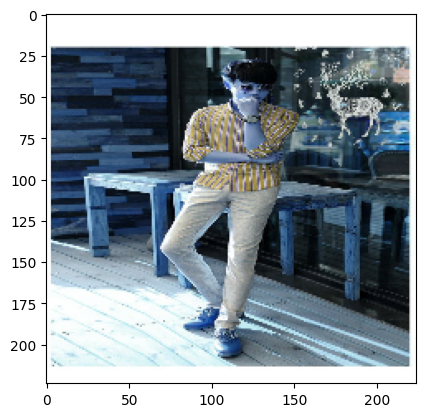

<Figure size 640x480 with 0 Axes>

new_test/002485.jpg
PREDICTED:  trousers


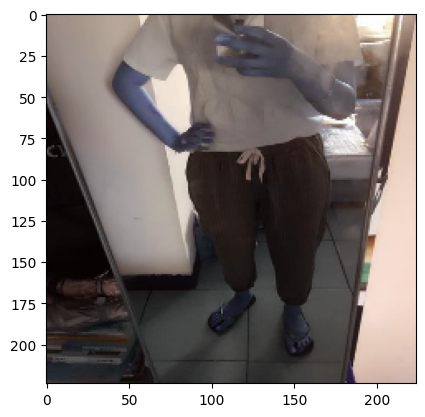

new_test/013181.jpg
PREDICTED:   short sleeve top


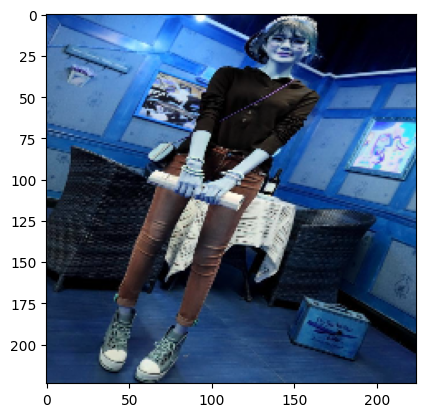

<Figure size 640x480 with 0 Axes>

new_test/003805.jpg
PREDICTED:  long sleeve top


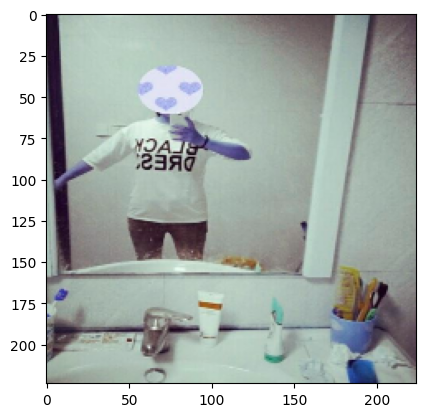

<Figure size 640x480 with 0 Axes>

new_test/006237.jpg
PREDICTED:  trousers


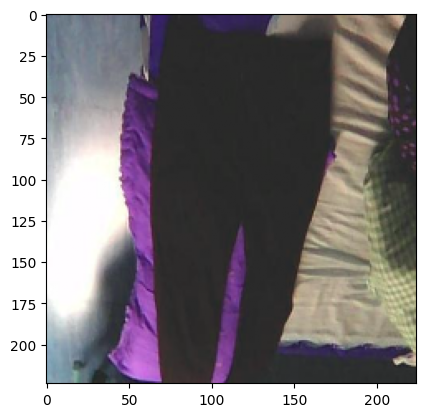

<Figure size 640x480 with 0 Axes>

In [83]:
import cv2
import itertools
import random
from collections import Counter
from glob import iglob
import numpy as np

classes = [' long sleeve top',
' short sleeve top',
' shorts',
' skirt',
' trousers',
'long sleeve dress',
'long sleeve top',
'short sleeve dress',
'short sleeve top',
'shorts',
'trousers',
'vest dress']

def load_image(filename):
    print(filename)
    img = cv2.imread(filename)
    img = cv2.resize(img, (224,224) )
    img = img /255
    return img

def predict(image):
    probabilities = model.predict(np.asarray([image]))[0]
    class_idx = np.argmax(probabilities)
    return classes[class_idx]

for idx, filename in enumerate(random.sample(xtest, 5)):
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: ", prediction)
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()